# Sentiment Analysis on Amazon Fine Food Reviews

In this notebook, I explore sentiment analysis using two different approaches:

1. **VADER (Valence Aware Dictionary and sEntiment Reasoner)** – a rule-based model designed for short social text.
2. **RoBERTa (via HuggingFace Transformers)** – a modern transformer-based model pre-trained and fine-tuned for sentiment classification.

Using the Amazon Fine Food Reviews dataset, I:

- Clean and inspect the raw reviews  
- Apply both VADER and RoBERTa to score sentiment  
- Compare how the two methods behave across different star ratings  
- Visualize patterns and discuss where the models agree or disagree

The goal is not only to reproduce the tutorial, but to understand **how each model behaves** and what that means in practice.


## Reading the data and importing libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
nltk.data.path.append('/kaggle/working')
nltk.data.path.append('/kaggle/input')
nltk.download('averaged_perceptron_tagger', download_dir='/kaggle/working')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('punkt', download_dir='/kaggle/working')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /kaggle/working...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /kaggle/working...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Loading and Basic Cleaning

I start by loading the Amazon Fine Food Reviews dataset. Each row contains a star rating (`Score`) and the corresponding review text (`Text`).

To prepare the data for analysis:

- I keep only the columns needed for this project (score + text)
- I drop missing values
- I optionally filter out neutral (3-star) reviews when converting to a binary sentiment label later


In [34]:
# Load the raw Amazon Fine Food Reviews dataset
df = pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [35]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Exploratory Data Analysis

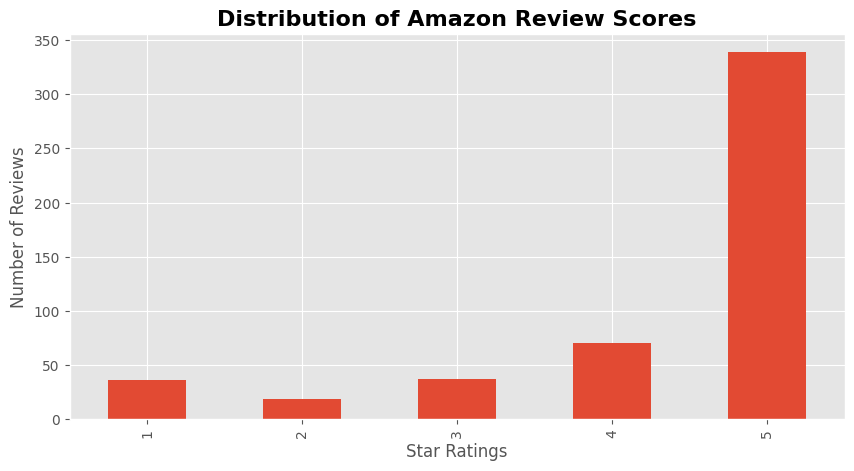

In [36]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', figsize = (10,5))
ax.set_title('Distribution of Amazon Review Scores', fontsize=16, weight='bold')
ax.set_xlabel('Star Ratings', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
sns.set_theme(style="whitegrid")
plt.show()

### Distribution of Star Ratings

The bar chart above shows how many reviews exist for each star rating.

The distribution is heavily skewed towards **4 and 5-star reviews**, which is common in product review datasets. This imbalance is important to keep in mind, because it can make models look better than they are if they mostly see positive examples.


## Natural Language Toolkit

In [37]:
ex = df['Text'][22]
print(ex)

I can remember buying this candy as a kid and the quality hasn't dropped in all these years. Still a superb product you won't be disappointed with.


In [38]:
tokens = nltk.word_tokenize(ex)
tokens[:10]

['I', 'can', 'remember', 'buying', 'this', 'candy', 'as', 'a', 'kid', 'and']

In [39]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('I', 'PRP'),
 ('can', 'MD'),
 ('remember', 'VB'),
 ('buying', 'VBG'),
 ('this', 'DT'),
 ('candy', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('kid', 'NN'),
 ('and', 'CC')]

In [40]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  can/MD
  remember/VB
  buying/VBG
  this/DT
  candy/NN
  as/IN
  a/DT
  kid/NN
  and/CC
  the/DT
  quality/NN
  has/VBZ
  n't/RB
  dropped/VBN
  in/IN
  all/PDT
  these/DT
  years/NNS
  ./.
  Still/RB
  a/DT
  superb/JJ
  product/NN
  you/PRP
  wo/MD
  n't/RB
  be/VB
  disappointed/VBN
  with/IN
  ./.)


## VADER (Valence Aware Dictionary and sEntiment Reasoner) Seniment Scoring

Next, we evaluate the sentiment of the review text using NLTK’s `SentimentIntensityAnalyzer`.

This tool assigns negative, neutral, and positive sentiment scores by examining the contribution of individual words.

The method works like a lightweight bag-of-words model where stopwords are filtered out and each remaining token influences the final score.

In [41]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from tqdm.notebook import tqdm

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [42]:
sia.polarity_scores("I am very happy!")

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [43]:
sia.polarity_scores("This is the worst day ever.")

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [44]:
sia.polarity_scores(ex)

{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'compound': 0.7687}

In [45]:
from tqdm.notebook import tqdm
from tqdm.auto import tqdm

res = {}

# Iterate through each review and compute VADER sentiment scores
for i, row in tqdm(df.iterrows(), total=len(df), desc="Scoring sentiment"):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

Scoring sentiment:   0%|          | 0/500 [00:00<?, ?it/s]

In [46]:
# Convert the dictionary of scores to a DataFrame
vaders = pd.DataFrame(res).T
# Add an Id column to the original df to enable a clean merge
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
# Merge VADER scores back onto the original data
vaders = vaders.merge(df, on='Id', how='left')

In [47]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plotting Results from VADER

/tmp/ipykernel_55/3729982535.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=vaders, x='Score',y='compound',estimator=np.mean,errorbar=('ci', 95), palette='viridis')


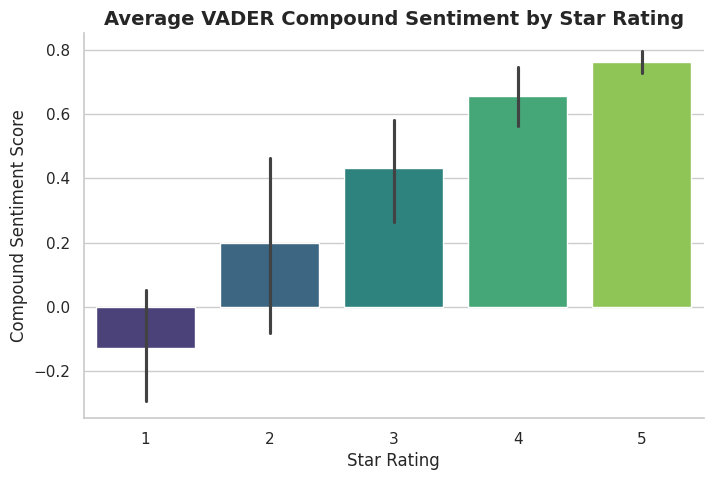

In [48]:
plt.figure(figsize=(8,5))
ax = sns.barplot(data=vaders, x='Score',y='compound',estimator=np.mean,errorbar=('ci', 95), palette='viridis')
ax.set_title('Average VADER Compound Sentiment by Star Rating', fontsize=14, weight='bold')
ax.set_xlabel('Star Rating')
ax.set_ylabel('Compound Sentiment Score')

sns.despine()
plt.show()


### VADER Compound Scores vs Star Ratings

Above I plot the distribution of VADER compound scores across star ratings.

**Observations:**

- 1–2 star reviews have mostly negative compound scores.
- 4–5 star reviews are strongly positive and tightly clustered near +1.
- 3-star reviews (if included) tend to sit near 0, which matches “mixed” sentiment.

This suggests that VADER is able to capture the overall direction of the rating signal despite being a simple lexicon-based model.


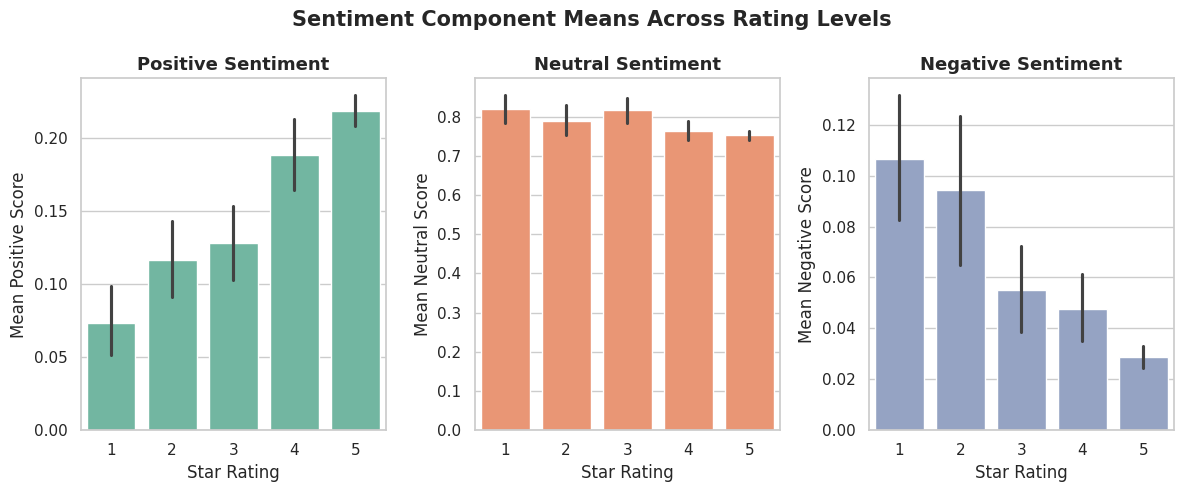

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

components = [('pos','Positive'), ('neu','Neutral'), ('neg','Negative')]
palette = sns.color_palette('Set2', 3)

for (comp, label), color, ax in zip(components, palette, axs):
    sns.barplot(data=vaders,x='Score',y=comp, ax=ax,color=color)
    ax.set_title(f'{label} Sentiment', fontsize=13, weight='bold')
    ax.set_xlabel('Star Rating')
    ax.set_ylabel(f'Mean {label} Score')

plt.suptitle('Sentiment Component Means Across Rating Levels', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

### Positive, Neutral, and Negative Components by Rating

Instead of looking only at the compound score, I also examine how each VADER component (`pos`, `neu`, and `neg`) behaves across star ratings.

This helps answer questions like:

- Do 1-star reviews really contain more negative language?
- How much neutral language is present even in positive reviews?
- Are 5-star reviews mostly positive, or a mix of neutral and positive?

**Observation:**  
As expected, the positive component increases steadily with star rating, while the negative component falls. Neutral sentiment stays relatively stable, suggesting that changes in polarity (positive vs negative) are more informative than changes in neutrality.



## RoBERTa (Robustly Optimized BERT Approach) Pretrained Model

To complement the lexicon-based VADER approach, I also use a pre-trained transformer model from HuggingFace.

I load the `cardiffnlp/twitter-roberta-base-sentiment` model, which has been fine-tuned for sentiment analysis. Unlike VADER, RoBERTa:

- operates on contextual embeddings rather than static word scores  
- can capture word order, negation, and subtle phrasing  
- tends to perform better on complex or less obvious sentiment

In this section, I apply RoBERTa to the same reviews and compare its scores to VADER and the original star ratings.


In [51]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [53]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
# Load tokenizer and model weights from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [55]:
print(ex)
sia.polarity_scores(ex)

I can remember buying this candy as a kid and the quality hasn't dropped in all these years. Still a superb product you won't be disappointed with.


{'neg': 0.0, 'neu': 0.768, 'pos': 0.232, 'compound': 0.7687}

In [62]:
encoded_text = tokenizer(ex, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.009479419), 'roberta_neu': np.float32(0.056938652), 'roberta_pos': np.float32(0.93358195)}


In [63]:
# Helper function to get sentiment scores from RoBERTa for a single text
def polarity_scores_roberta(ex):
    encoded_text = tokenizer(ex, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [70]:
res = {}
# Apply RoBERTa sentiment to each review (or a sampled subset for speed)
for i, row in tqdm(df.iterrows(), total=len(df), desc="Scoring sentiment"):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
    
        roberta_result= polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

Scoring sentiment:   0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [71]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
# Combine VADER and RoBERTa scores into a single results DataFrame
results_df = results_df.merge(df, on='Id', how='left')

## Comparing and Combining Scores and Results between VADER and RoBERTa Models

In [73]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

To understand how the two models behave relative to each other, I look at pairwise relationships between their negative, neutral, and positive scores.

The pairplot below shows:

- whether both models agree on what is “positive” vs “negative”  
- how tightly each model’s scores correlate with star ratings  
- potential cases where one model is confident and the other is uncertain


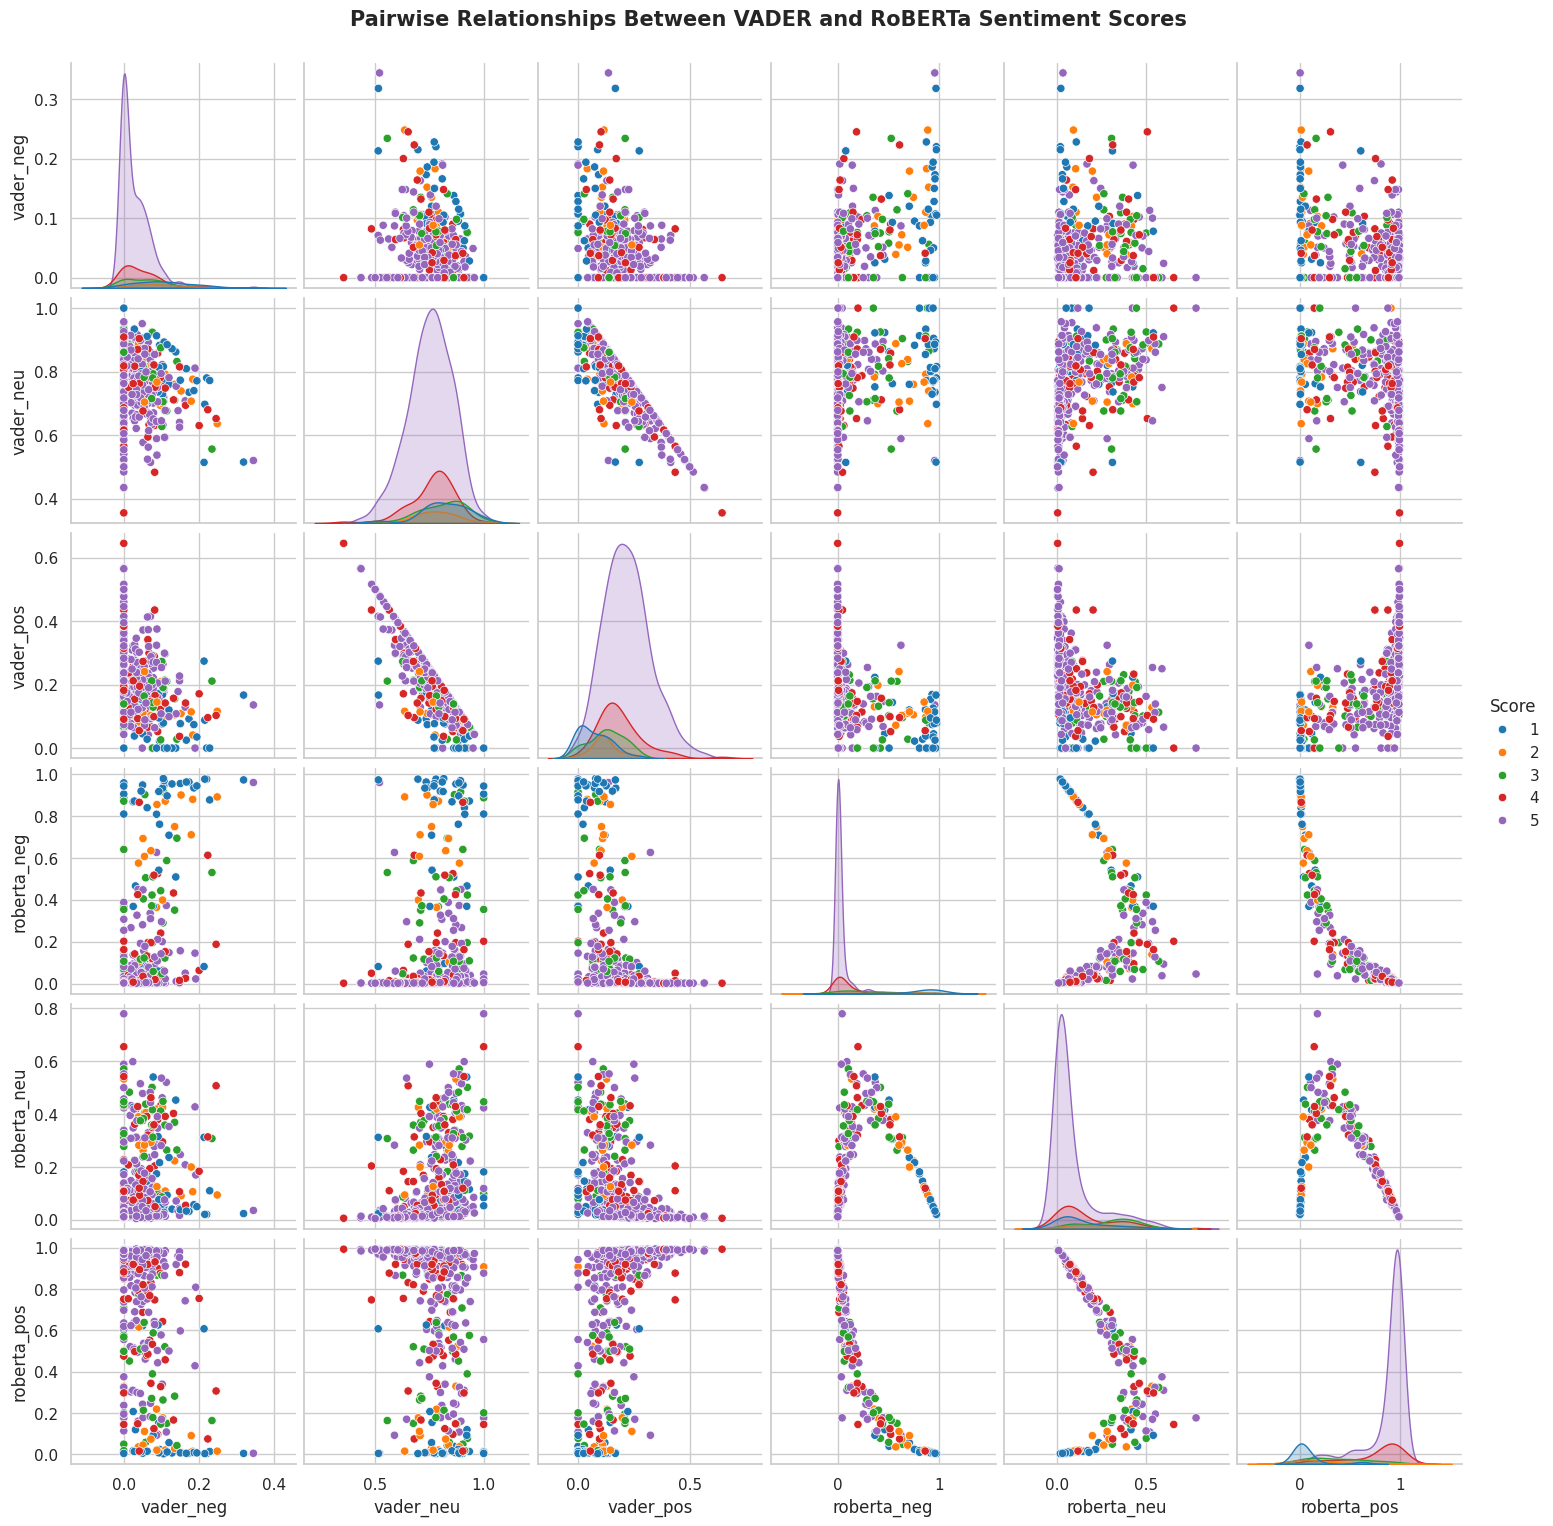

In [76]:
sns.set_theme(style="whitegrid")

plot_vars = [
    'vader_neg', 'vader_neu', 'vader_pos',
    'roberta_neg', 'roberta_neu', 'roberta_pos'
]

g = sns.pairplot(
    data=results_df,
    vars=plot_vars,
    hue='Score',
    palette='tab10',
    diag_kind='kde',
    corner=False
)

g.fig.suptitle(
    "Pairwise Relationships Between VADER and RoBERTa Sentiment Scores",
    y=1.02,
    fontsize=15,
    fontweight='bold'
)

plt.show()


**Interpretation:**

- Positive scores from both models increase with the star rating, which is a good sign of alignment.
- RoBERTa scores tend to be more extreme (closer to 0 or 1), reflecting its confidence on many reviews.
- VADER scores are often more conservative, especially on mixed or neutral-sounding reviews.


## Reviewing Examples

In [78]:
results_df.query('Score == 1').sort_values(
    'roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [79]:
results_df.query('Score == 1').sort_values('vader_pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [80]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [81]:
results_df.query('Score == 5').sort_values('vader_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## The Transformers Pipeline

In [83]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu


In [84]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [85]:
sent_pipeline('I hate broccoli.')

[{'label': 'NEGATIVE', 'score': 0.9982413053512573}]

## Conclusions and Takeaways

In this project I:

- Built a full sentiment analysis workflow on real Amazon product reviews
- Used **VADER** to compute lexicon-based sentiment scores (neg/neu/pos/compound)
- Used **RoBERTa** to generate transformer-based sentiment probabilities
- Compared both models across star ratings and individual components

**Key lessons:**

- The distribution of star ratings is heavily imbalanced towards positive reviews, which can make models appear better than they really are on minority classes.
- VADER provides a fast and interpretable baseline; it tracks the rating signal reasonably well using only word-level features.
- RoBERTa captures more nuanced sentiment and tends to produce more confident, polarized scores, especially on clearly positive or negative reviews.
- Visualizing sentiment scores by rating level (boxplots, bar charts, pairplots) is crucial for understanding how models behave beyond just accuracy.

**Possible next steps:**

- Train a supervised classifier (e.g., logistic regression or fine-tuned transformer) using the `Sentiment` label.
- Balance the dataset (undersampling/oversampling) to improve performance on negative reviews.
- Deploy the model in a simple web app (e.g., Flask) to score custom text inputs.


## The End